In [1]:
from numpy.linalg import norm
from gensim.models import FastText
import sys
import os.path as op
import random
import pandas as pd
import numpy as np 

def kmeans(data, k, maxIterations, distance="cosinus", vectorColumn="text_vec"):

    random.seed(0)
    # Initialize centroids randomly
    centroids = initialise_centroids(np.asarray(data[vectorColumn].values.tolist()), k)   # [ arr, arr, .., arr ]

    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = [np.zeros((300,)) for i in range(k)]
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations, maxIterations):
        print("Iterations:", iterations)
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        data["label"] = data[vectorColumn].map(lambda d: getLabelForEachDataPoint(d, centroids, distance=distance)).astype('category')
        #labels = getLabelForEachDataPoint(data, centroids)   

        # Assign centroids based on datapoint labels
        centroids = data.groupby(by="label").apply(lambda value: getMean(value, vectorColumn))#.mean()

    # We can get the labels too by calling getLabels(dataSet, centroids)
    return data


def getMean(data, vectorColumn):
    matrix_form = np.asarray(data[vectorColumn].values.tolist())
    return np.sum(matrix_form,axis=0) / matrix_form.shape[0]


def updateCentroids(data, labels, k):
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.

    # recalculate centroids
    index = 0
    for cluster in labels:
        old_centroids[index] = data[index]
        data[index] = np.mean(cluster, axis=0).tolist()
        index += 1

def initialise_centroids(data, k):
    random_indices = random.sample(range(len(data)), k)
    return [data[i] for i in random_indices]


def shouldStop(oldCentroids, centroids, iterations, maxIterations):
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
    if iterations > maxIterations: return True
#    return all([(centroids[i] == oldCentroids[i]).all() for i in range(len(centroids))])#(oldCentroids == centroids).all()
    return all([np.array_equal(centroids[i], oldCentroids[i]) for i in range(len(centroids))])#(oldCentroids == centroids).all()

def cosinus_similarity(a, b):
    return np.inner(a,b)/(norm(a)*norm(b))


# Calculates euclidean distance between
# a data point and all the available cluster
# centroids.      
def getLabelForEachDataPoint(tweet_vec, centroids, distance="cosinus"):
     
    if distance == "cosinus": return max([(i, cosinus_similarity(tweet_vec, center)) for i, center in enumerate(centroids)], key=lambda t: t[1])[0]
    elif distance == "euclidean" : return min([(i, np.linalg.norm(tweet_vec-center))for i, center in enumerate(centroids)], key=lambda t: t[1])[0]
    else: print("ERROR: Wrong distance meausure!")
        
        
        
basename = "/home/adrian/PhD/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import tweet_vectorizer

from preprocess import Preprocess
prep = Preprocess()

        
def preprocess_tweet(tweet):
    tweet = prep.replace_contractions(tweet)
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="delete", mode_Mentions="delete")
    tweet = prep.remove_repeating_characters(tweet)
    tweet = prep.remove_repeating_words(tweet)
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)
    tweet = prep.to_lowercase(tweet)
    tweet = prep.remove_non_ascii(tweet)
    tweet = prep.replace_numbers(tweet)
    tweet = prep.remove_stopwords(tweet, include_personal_words=False, include_negations=False)
    tweet = [word for word in tweet if word not in ["diabetes", "diabetic"]]
    return tweet

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/adrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:

#data = pd.read_parquet("/home/adrian/PhD/Data/Tweets20190708/matching-tweets_diab_noRT-noBots_personal_noJokes_locationUS_geoCityCodeNotNull_emotions_gender-typeDiab.parquet").sample(n=100)
data = pd.read_parquet("/home/adrian/PhD/Data/Tweets20190708/matching-tweets_diab_noRT-noBots_personal_noJokes_locationUS_geoCityCodeNotNull_emotions_gender-typeDiab.parquet", columns=["id", "text", "user_name", "gender", "typeDiabetes", "geo_adm1_code", "geo_name", "user_location", "place_full_name"])
model = FastText.load("/home/adrian/PhD/Data/FastText_embedding_20190703/ft_wordembeddings_dim300_minCount5_URL-User-toConstant_iter10_20190703")
print(data.shape)
#df = readFile(filename, columns="id, created_at, text, user_screen_name, user_name")
#df = df.reset_index("user_name", drop=True)#.reset_index(drop=True)
#data = data.reset_index(drop=True)

data["text_vec"] = data.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model))
data["prep"] = data.text.map(lambda tweet: preprocess_tweet(tweet))
print(data.columns)
data.head()


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(46407, 9)
no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!
Index(['id', 'text', 'user_name', 'gender', 'typeDiabetes', 'geo_adm1_code',
       'geo_name', 'user_location', 'place_full_name', 'text_vec', 'prep'],
      dtype='object')


,id,text,user_name,gender,typeDiabetes,geo_adm1_code,geo_name,user_location,place_full_name,text_vec,prep
0,1.129140e+18,When I was initially diagnosed with #type2diab...,Lynda Jimenez,1,1,AZ,Phoenix,"Phoenix, AZ",None,"[0.091667205, 0.032091808, -0.081855804, -0.07...","[initially, diagnosed, #type2diabetes, almost,..."
1,1.102559e+18,Later Twitter it's back to sleep for a nap wok...,Deanna Porter Weick,0,0,MI,Monroe,"Monroe, MI",None,"[0.16888438, -0.029450605, 0.0862785, -0.06317...","[later, twitter, back, sleep, nap, woke, 5:30,..."
2,1.039046e+18,Ugh not ready for this 3hour glucose test tomo...,Esmeralda,2,0,CA,Hemet,Hemet CA,None,"[0.07679383, -0.038904045, 0.13049835, -0.2382...","[ugh, ready, 3hour, glucose, test, tomorrow]"
3,9.581800e+17,@hotfunkytown They also lock up diabetic suppl...,Joyce Pride,0,0,MO,Maryville,"Maryville, Missouri",None,"[0.12150481, 0.11272085, 0.11174324, -0.108990...","[also, lock, supplies, need, gloria, feel, ash..."
4,9.151822e+17,@I_TheeWed “Hey mom! I know you’re dreading th...,Hot Mess Momma🍁,2,0,OK,Oklahoma City,Illinois ✈️ Oklahoma,None,"[0.06801716, 0.14217816, 0.018431958, -0.32431...","[hey, mom, know, dreading, glucose, test, alre..."


In [6]:
data.groupby(by="user_name").count().shape

(29389, 10)

In [3]:
from sklearn.metrics import silhouette_score
MAX_ITERATIONS = 150

Ncluster = 30

res=kmeans(data, Ncluster, MAX_ITERATIONS, distance="cosinus", vectorColumn="text_vec")
silhouette_avg=silhouette_score(np.asarray(data["text_vec"].values.tolist()), res["label"].values, metric="cosine")
print(silhouette_avg)
res.head()


Iterations: 0


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


Iterations: 1
Iterations: 2
Iterations: 3
Iterations: 4
Iterations: 5
Iterations: 6
Iterations: 7
Iterations: 8
Iterations: 9
Iterations: 10
Iterations: 11
Iterations: 12
Iterations: 13
Iterations: 14
Iterations: 15
Iterations: 16
Iterations: 17
Iterations: 18
Iterations: 19
Iterations: 20
Iterations: 21
Iterations: 22
Iterations: 23
Iterations: 24
Iterations: 25
Iterations: 26
Iterations: 27
Iterations: 28
Iterations: 29
Iterations: 30
Iterations: 31
Iterations: 32
Iterations: 33
Iterations: 34
Iterations: 35
Iterations: 36
Iterations: 37
Iterations: 38
Iterations: 39
Iterations: 40
Iterations: 41
Iterations: 42
Iterations: 43
Iterations: 44
Iterations: 45
Iterations: 46
Iterations: 47
Iterations: 48
Iterations: 49
Iterations: 50
Iterations: 51
Iterations: 52
Iterations: 53
Iterations: 54
Iterations: 55
Iterations: 56
Iterations: 57
Iterations: 58
Iterations: 59
Iterations: 60
Iterations: 61
Iterations: 62
Iterations: 63
Iterations: 64
Iterations: 65
Iterations: 66
Iterations: 67
Iter

,id,text,user_name,gender,typeDiabetes,geo_adm1_code,geo_name,user_location,place_full_name,text_vec,prep,label
0,1.129140e+18,When I was initially diagnosed with #type2diab...,Lynda Jimenez,1,1,AZ,Phoenix,"Phoenix, AZ",None,"[0.091667205, 0.032091808, -0.081855804, -0.07...","[initially, diagnosed, #type2diabetes, almost,...",4
1,1.102559e+18,Later Twitter it's back to sleep for a nap wok...,Deanna Porter Weick,0,0,MI,Monroe,"Monroe, MI",None,"[0.16888438, -0.029450605, 0.0862785, -0.06317...","[later, twitter, back, sleep, nap, woke, 5:30,...",11
2,1.039046e+18,Ugh not ready for this 3hour glucose test tomo...,Esmeralda,2,0,CA,Hemet,Hemet CA,None,"[0.07679383, -0.038904045, 0.13049835, -0.2382...","[ugh, ready, 3hour, glucose, test, tomorrow]",22
3,9.581800e+17,@hotfunkytown They also lock up diabetic suppl...,Joyce Pride,0,0,MO,Maryville,"Maryville, Missouri",None,"[0.12150481, 0.11272085, 0.11174324, -0.108990...","[also, lock, supplies, need, gloria, feel, ash...",3
4,9.151822e+17,@I_TheeWed “Hey mom! I know you’re dreading th...,Hot Mess Momma🍁,2,0,OK,Oklahoma City,Illinois ✈️ Oklahoma,None,"[0.06801716, 0.14217816, 0.018431958, -0.32431...","[hey, mom, know, dreading, glucose, test, alre...",3


In [4]:
res[["id", "text", "user_name", "gender", "typeDiabetes", "geo_adm1_code", "geo_name", "user_location", "place_full_name", "label"]].to_parquet("Tweets_groupLabel_20190715.parquet", engine="pyarrow", index=False)

In [4]:
from sklearn.metrics import silhouette_score
MAX_ITERATIONS = 150

Nclusters =  [80]
scores = []
for N in Nclusters:
    res=kmeans(data, N, MAX_ITERATIONS, distance="cosinus", vectorColumn="text_vec")
    score = silhouette_score(np.asarray(data["text_vec"].values.tolist()), res["label"].values, metric="cosine")
    print(score)
    print()
    scores.append(score)
    
print("Clusters:", Nclusters)
print("scores:", scores)




Iterations: 0


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


Iterations: 1
Iterations: 2
Iterations: 3
Iterations: 4
Iterations: 5
Iterations: 6
Iterations: 7
Iterations: 8
Iterations: 9
Iterations: 10
Iterations: 11
Iterations: 12
Iterations: 13
Iterations: 14
Iterations: 15
Iterations: 16
Iterations: 17
Iterations: 18
Iterations: 19
Iterations: 20
Iterations: 21
Iterations: 22
Iterations: 23
Iterations: 24
Iterations: 25
Iterations: 26
Iterations: 27
Iterations: 28
Iterations: 29
Iterations: 30
Iterations: 31
Iterations: 32
Iterations: 33
Iterations: 34
Iterations: 35
Iterations: 36
Iterations: 37
Iterations: 38
Iterations: 39
Iterations: 40
Iterations: 41
Iterations: 42
Iterations: 43
Iterations: 44
Iterations: 45
Iterations: 46
Iterations: 47
Iterations: 48
Iterations: 49
Iterations: 50
Iterations: 51
Iterations: 52
Iterations: 53
Iterations: 54
Iterations: 55
Iterations: 56
Iterations: 57
Iterations: 58
Iterations: 59
Iterations: 60
Iterations: 61
Iterations: 62
Iterations: 63
Iterations: 64
Iterations: 65
Iterations: 66
Iterations: 67
Iter

In [ ]:
Seed 0 
Clusters: [20, 30, 40]
scores: [0.043972853725834864, 0.044009471811909034, 0.03991497842784286]

Clusters: [80]
scores: [0.04088788373382824]


#Clusters: [20, 30, 40]
#scores: [0.033042025363564785, 0.043416428585740074, 0.03729919029046307]

(6930, 200)


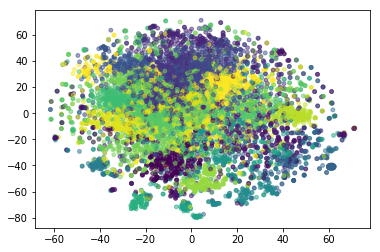

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
model_TSNE = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

X_tsne = np.asarray(res_dsma["text_vec"].values.tolist())
print(X_tsne.shape)
Y=model_TSNE.fit_transform(X_tsne)
 
plt.scatter(Y[:, 0], Y[:, 1], c=res_dsma["label"], s=15,alpha=.5)
 

#for j in range(len(sentences)):    
#   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
#   print ("%s %s" % (assigned_clusters[j],  sentences[j]))
  
plt.show()

In [4]:
def calc_distance_to_groupCenter(group, topN, vectorColumn="text_vec"):
    matrix_form = np.asarray(group[vectorColumn].values.tolist())
    groupCenter = np.sum(matrix_form,axis=0) / matrix_form.shape[0]
    
    group["cos_similarity_to_center"] = group["text_vec"].map(lambda vec: cosinus_similarity(vec, groupCenter))
    
    group.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    
    print("------")
    print("Label:", group["label"].values[0], "(Number tweets: {})".format(group.shape[0]))
    print("------")
    for i, row in group.head(topN).iterrows():
        print(row["text"])
        print()   
    
    return(group)



def print_closest_tweets_to_groupCenter(data, topN, vectorColumn="text_vec"):

    print("================")
    print("Closest tweets:")
    print("================")
    data = data.groupby(by="label", as_index=False) \
              .apply(lambda data: calc_distance_to_groupCenter(data, topN,"text_vec")) \
              .reset_index(drop=True)
    return(data)

    
res1 = print_closest_tweets_to_groupCenter(res, 10, "text_vec")
res1.head()

#res_dsma1 = print_closest_tweets_to_groupCenter(res_dsma, 10, "text_vec")
#res_dsma1.head()

Closest tweets:
------
Label: 0 (Number tweets: 1513)
------
Q1: I have a really hard time being content. I'm in a good place right now w/ most things in life but still antsy for new adventures. #dsma

People often ask what a good night looks like for Hazel with diabetes and it really comes down to staying in range… https://t.co/RF0agUTHGd

@zisekaiase Thank you! a little nervous lol I'm going to dr. today&amp; get my blood work again for my diabetes I've been eating good food 👌🏼🤗🌹🌟

good morning i’m awake ONLY to give max his insulin however i am also wishing @tatehxppy a good day thank you for coming to my ted talk

Well they did say my legs are healing pretty good so that is a good sign now I need to see if I can get a primary doctor for my diabetes

@rgburns95 Oh good I'm glad it went well. Sorry you're still in pain. I have unfortunate news I am for sure Diabetic type 2 Hypoglasimic.

@mollyschreiber Good luck!! This is good to know about because I’m going through insulin like wat

/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars
/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


------
Label: 7 (Number tweets: 2916)
------
Thanks CO for capping insulin costs I know too many people that suffer bc of the high prices of insulin you rock I love my state

I know the fear of people who take insulin. I am one of them. Even with insurance, insulin is expensive. We need so… https://t.co/evwjrK3XhO

Insulin manu. may be doing good donating insulin to PR but others there are still locked out b/c price. #Insulin4All https://t.co/tQbOYv98sD

@mdb2 My insulin is $1800. Utterly ridiculous! I can't afford mine either and so.etimes I have to go to an urgent care or ER for insulin.

@eugenegu Insulin is unaffordable unless you have good insurance. Type 1 diabetics die w/o insulin. Yet we hear ver… https://t.co/fQ8nNCKd5V

Cost of insulin is outrageous! This could be me in 10 years😥 if my son can’t afford #insulin. I’m sure there are th… https://t.co/Vq43r78qZh

You can't eat all the food you love without getting insulin, so if your body still makes it - help understand why Phar

------
Label: 19 (Number tweets: 284)
------
We wouldn’t dare treat someone with type 1 diabetes who went into insulin shock, then send her home without furthe… https://t.co/DS1QJIB4qq

@scottnicholls Someone went into diabetic shock or something when we were by like the North Pole. Crazy. She was ok by the end of the flight

@ispypanda like it was insulin and I was going into diabetic shock...

@SuzeVista Some people would binge eat thinking they are going to die and then go into insulin shock from the trauma.

Locked in an insane asylum and be put into an insulin coma, an ice bath, maybe some shock treatment. Die in unsafe… https://t.co/LJGizjQxTq

@Gusbuckets One time I called Jimmy Kimmel to tell him I ate all my kid's medication. Let's say they were in shock. Well, diabetic shock.

So I went into shock after a cortisone shot (potentially insulin shock because I'm hypoglycemic/ pre-diabetic) and… https://t.co/baXeiZasvC

she was in diabetic shock and almost went into a coma and she

------
Label: 29 (Number tweets: 3970)
------
Makes me sad to discard insulin at work when i know thee are type I diabetics who use expired insulin because they can't afford treatment😭

how much insulin they have in their body at any given time. It also makes it less awkward to take insulin for a mea… https://t.co/QEY0grfxeR

People say Type II diabetes is insulin resistance. I think it means your body doesn't produce enough insulin. Feel like I'm doomed if wrong

@LowBudgetWolf rip, i feel fine tho not like throwing up type sick yet so we will see if i dont lower, might need to change my insulin

Well, sure, but you'd eventually need $1000/month in insulin...even if you stopped eating the Ramen.  It's good, th… https://t.co/Gx37hh0Kv1

Can't stress enough how much I need an insulin pump. It would help greatly!! I hate carrying around my insulin.

I wonder if all those tRump voters that need insulin or have a loved one using insulin are still happy with their v… https://t.co/o9iPgnbeAw

,id,text,user_name,gender,typeDiabetes,geo_adm1_code,geo_name,user_location,place_full_name,text_vec,prep,label,cos_similarity_to_center
0,8.675502e+17,Q1: I have a really hard time being content. I...,Hannah,1,1,VA,Arlington,"Arlington, VA",None,"[0.17556193, 0.15923001, 0.009927038, -0.17588...","[q1, really, hard, time, content, good, place,...",0,0.921351
1,9.997216e+17,People often ask what a good night looks like ...,mattlumpkin,2,1,CA,Los Angeles,Los Angeles,None,"[0.20377772, 0.15592591, 0.02057297, -0.216310...","[people, often, ask, good, night, looks, like,...",0,0.920690
2,8.807711e+17,@zisekaiase Thank you! a little nervous lol I'...,Danna Luvs Yanni,1,0,TX,George West,Yanni's House,None,"[0.19616403, 0.101651035, -0.007856799, -0.169...","[thank, little, nervous, lol, going, dr, today...",0,0.920587
3,1.109066e+18,good morning i’m awake ONLY to give max his in...,danielle🦎🚨,1,1,IL,Chicago,chicago,None,"[0.15946747, 0.16316384, 0.06140042, -0.252989...","[good, morning, awake, give, max, insulin, how...",0,0.920241
4,8.717470e+17,Well they did say my legs are healing pretty g...,Naskensethcar,1,0,NC,Mooresville,"Mooresville, NC",None,"[0.112308726, 0.02403156, -0.08087771, -0.1505...","[well, say, legs, healing, pretty, good, good,...",0,0.918613


In [8]:
from collections import Counter
import operator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from defines import Patterns, Emotions
from emotion_codes import UNICODE_EMOJI, EMOJI_TO_CATEGORY

topN = 10


analyzer = SentimentIntensityAnalyzer()

def preprocess_emot(tweet):
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="delete", mode_Mentions="delete")
    tweet = tweet.replace("nerve pain", "")
    tweet = tweet.replace("nerve damage", "")
    tweet = tweet.replace("pain of neuropathy", "")
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)
    tweet = prep.to_lowercase(tweet)
    tweet = [word for word in tweet if word not in ["healthcare"]]
    return tweet

def get_top_emojis(group, textColumn):
    emotico_dict = {}
    for i, row in group.iterrows():
        tweet = prep.replace_hashtags_URL_USER(row[textColumn], mode_URL="delete", mode_Mentions="delete")
        tweet = prep.tokenize(tweet)
        for word in tweet: 
            match_emoticon = Patterns.EMOTICONS_PATTERN.findall(word)
        
            # if emoticon found
            if match_emoticon:
                if match_emoticon[0] is not ":" and match_emoticon[0] is not ")":
                    if match_emoticon[0] in emotico_dict: emotico_dict[match_emoticon[0]] += 1
                    else : emotico_dict[match_emoticon[0]] = 1
                
            # if emoji found    
            if word in UNICODE_EMOJI: 
                emot_cat = EMOJI_TO_CATEGORY[UNICODE_EMOJI[word]]
                if emot_cat != "": 
                    if word in emotico_dict: emotico_dict[word] += 1
                    else : emotico_dict[word] = 1
                        
    return emotico_dict


def get_top_emot_words(group, textColumn):
    word_count_emot = {}
    for i, row in group.iterrows():
        for word in preprocess_emot(row[textColumn]):
            for emot in Emotions.emotions_full_list:
                if emot == word: 
                    if word in word_count_emot.keys(): word_count_emot[word] += 1
                    else: word_count_emot[word] = 1
    return word_count_emot
    

def get_top_primary_emotion(group, textColumn):
    
    word_count_primaryEmot = {"love":0, "joy":0, "surprise":0, 'anger':0, "sadness":0, "fear":0}
    
    for i, row in group.iterrows():
        # to prevent that for one tweet one emotion is counted several times. One tweet can have maximum one emotion of each category
        hit_joy = False
        hit_love = False
        hit_surprise = False
        hit_fear = False
        hit_sadness = False
        hit_anger = False
        for word in preprocess_emot(row[textColumn]):
#           for emot in Emotions.emotions_full_list:
#               if emot == word:
            if word == "cry" or word == "cried" or word == "crying" or word == "ashamed": 
                word_count_primaryEmot["sadness"] += 1
                hit_sadness = True
            elif word == "dreading": 
                word_count_primaryEmot["fear"] += 1                    
                hit_fear = True
            else: 
                if word in PrimaryEmotionTree_allwords["joy"] and hit_joy == False: 
                    word_count_primaryEmot["joy"] += 1
                    hit_joy = True
                if word in PrimaryEmotionTree_allwords["love"] and hit_love == False: 
                    word_count_primaryEmot["love"] += 1
                    hit_love = True
                if word in PrimaryEmotionTree_allwords["surprise"] and hit_surprise == False: 
                    word_count_primaryEmot["surprise"] += 1
                    hit_surprise = True
                if word in PrimaryEmotionTree_allwords["anger"] and hit_anger == False: 
                    word_count_primaryEmot["anger"] += 1
                    hit_anger = True
                if word in PrimaryEmotionTree_allwords["sadness"] and hit_sadness == False: 
                    word_count_primaryEmot["sadness"] += 1
                    hit_sadness = True
                if word in PrimaryEmotionTree_allwords["fear"] and hit_fear == False: 
                    word_count_primaryEmot["fear"] += 1
                    hit_fear = True              

                    
        # reset for emoticons / emoji
        #hit_joy = False
        #hit_love = False
        #hit_surprise = False
        #hit_fear = False
        #hit_sadness = False
        #hit_anger = False                    
        tweet = prep.replace_hashtags_URL_USER(row[textColumn], mode_URL="delete", mode_Mentions="delete")
        tweet = prep.tokenize(tweet)
        for word in tweet: 
            match_emoticon = Patterns.EMOTICONS_PATTERN.findall(word)
        
            # if emoticon found
            if match_emoticon:
                if match_emoticon[0] is not ":" and match_emoticon[0] is not ")":
                    try:
                        if EMOTICONS[match_emoticon[0]] == "EMOT_JOY" and hit_joy == False: 
                            word_count_primaryEmot["joy"] += 1
                            hit_joy = True
                        if EMOTICONS[match_emoticon[0]] == "EMOT_LOVE" and hit_love == False: 
                            word_count_primaryEmot["love"] += 1
                            hit_love = True
                        if EMOTICONS[match_emoticon[0]] == "EMOT_SURPRISE" and hit_surprise == False: 
                            word_count_primaryEmot["surprise"] += 1
                            hit_surprise = True 
                        if EMOTICONS[match_emoticon[0]] == "EMOT_ANGER" and hit_anger == False: 
                            word_count_primaryEmot["anger"] += 1
                            hit_anger = True
                        if EMOTICONS[match_emoticon[0]] == "EMOT_SADNESS" and hit_sadness == False: 
                            word_count_primaryEmot["sadness"] += 1
                            hit_sadness = True
                        if EMOTICONS[match_emoticon[0]] == "EMOT_FEAR" and hit_fear == False: 
                            word_count_primaryEmot["fear"] += 1                    
                            hit_fear = True
                    except:
                        print("{} not found")

            # if emoji found    
            if word in UNICODE_EMOJI: 
                emot_cat = EMOJI_TO_CATEGORY[UNICODE_EMOJI[word]]
                if emot_cat != "": 
                    for emo in emot_cat.split(" "): # some smilies are attributed to several emotions

                        if emo == "EMOT_JOY" and hit_joy == False: 
                            word_count_primaryEmot["joy"] += 1
                            hit_joy = True
                        if emo == "EMOT_LOVE" and hit_love == False: 
                            word_count_primaryEmot["love"] += 1
                            hit_love = True
                        if emo == "EMOT_SURPRISE" and hit_surprise == False: 
                            word_count_primaryEmot["surprise"] += 1
                            hit_surprise = True 
                        if emo == "EMOT_ANGER" and hit_anger == False: 
                            word_count_primaryEmot["anger"] += 1
                            hit_anger = True
                        if emo == "EMOT_SADNESS" and hit_sadness == False: 
                            word_count_primaryEmot["sadness"] += 1
                            hit_sadness = True
                        if emo == "EMOT_FEAR" and hit_fear == False: 
                            word_count_primaryEmot["fear"] += 1                    
                            hit_fear = True     
                            
        
        if hit_fear == False and hit_sadness == False and hit_anger == False and hit_joy == False and hit_love == False and  hit_surprise == False:
            if "good" in row[textColumn]: pass
            elif "Good" in row[textColumn] : pass
            elif "Bad" in row[textColumn]: pass
            elif "bad" in row[textColumn]: pass
            elif 'feel' in row[textColumn]: pass
            else: print(row[textColumn], "\n")
                
            
    return word_count_primaryEmot
    
    
def global_term_frequency(data, textColumn):
    word_counter = {}
    for i, row in data.iterrows():
        for word in preprocess_tweet(row[textColumn]):
            if word in word_counter: word_counter[word] += 1
            else: word_counter[word] = 1    

    return word_counter

def topN_keywords(group, topN, textColumn, global_term_frequency_dict):

    
    N_group = group.shape[0]
    
    print("Calculate topWords for group {}..".format(group["label"].values[0]))
    word_counter = {}
    for i, row in group.iterrows():
        for word in preprocess_tweet(row[textColumn]):
            if word in word_counter: word_counter[word] += 1
            else: word_counter[word] = 1
         
    topKeywords = dict(sorted(word_counter.items(), key=operator.itemgetter(1), reverse=True)[:topN])
    topKeywords_str = ", ".join(str(e) for e in topKeywords.keys())

    #print("Calculate topWords inverse (N_group / N_global) for group {}..".format(group["label"].values[0]))
    word_counter_inv = {k: v / global_term_frequency_dict[k] for k, v in word_counter.items() if v > 100} # consider only words that occur often in a group, otherwise there is too much noise
    
    topKeywords_inv = dict(sorted(word_counter_inv.items(), key=operator.itemgetter(1), reverse=True)[:topN])
    topKeywords_str_inv = ", ".join(str(e) for e in topKeywords_inv.keys())

    # count most occuring emotional words                    
    word_count_emot = get_top_emot_words(group, textColumn)  
    topKeywords_emot = sorted(word_count_emot.items(), key=operator.itemgetter(1), reverse=True)
#    topKeywords_emot_str = ", ".join("{}: {}".format(emoji, np.round(occ*100/N_group,1)) for emoji, occ in topKeywords_emot[:topN])
    topKeywords_emot_str = ", ".join("{}".format(emoji) for emoji, occ in topKeywords_emot[:topN])
    #print("top emotional keywords:")
    #print(topKeywords_emot_str)
    
    # count most occuring emojis / emoticons
    top_emojis = sorted(get_top_emojis(group, textColumn).items(), key=operator.itemgetter(1), reverse=True)
#    top_emojiEmoticon = ", ".join("{}({})".format(emoji, np.round(occ*100/N_group,1)) for emoji, occ in top_emojis[:topN])
    top_emojiEmoticon = ", ".join("{}".format(emoji) for emoji, occ in top_emojis[:topN])
    #print("top emoji:", top_emojiEmoticon)
    
    # get most occuring emot words + emojis combined
    emot_combined = sorted(topKeywords_emot+top_emojis, key=operator.itemgetter(1), reverse=True)
    emot_combined_str = ", ".join("{}({})".format(emoji, np.round(occ*100/N_group,1)) for emoji, occ in emot_combined[:topN])
    #print("top comb:")
    #print(emot_combined)
    
    word_count_primaryEmot = get_top_primary_emotion(group, textColumn)
    word_count_primaryEmot = [(key, value) for key, value in word_count_primaryEmot.items()]
    print(word_count_primaryEmot)
    primaryEmotion_str = sorted(word_count_primaryEmot, key=operator.itemgetter(1), reverse=True)
    print(primaryEmotion_str)
    sum_occ_primary_emot = sum([pair[1] for pair in primaryEmotion_str]) # divided by sum of all primary emotions found, BUT tweets with emoticons that are not categorised in a emotion category neglected, similar tweets with "good" and "bad"
    primaryEmotion_dict = {emot:np.round(occ*100/sum_occ_primary_emot,1) for emot, occ in primaryEmotion_str}
    primaryEmotion_str = ", ".join("{}({})".format(emot, np.round(occ*100/sum_occ_primary_emot,1)) for emot, occ in primaryEmotion_str)
    print(primaryEmotion_str)
    
    temp = "".join("{{}}")
    
    # Take only closest tweet to center for one user to avoid that all tweets we put in the dataframe come from the same user
    grp_oneTweetPerUser = group.groupby(by="user_name", as_index=False).apply(lambda grp_user: grp_user.head(1))
    grp_oneTweetPerUser.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    text = ""
    for index, row in grp_oneTweetPerUser.head(10).iterrows():
        text += row["text"]+" (cos sim. to center: "+str("%.2f" % row["cos_similarity_to_center"])+")  #  .=.=.=. NEXT.=.=.=.     "

    # create percentages of Male, Female, Unknown in groups
    gender_count = group.gender.value_counts()
    if 0 not in gender_count.index: gender_count[0] = 0
    if 1 not in gender_count.index: gender_count[1] = 0
    if 2 not in gender_count.index: gender_count[2] = 0

    gender_freq_M = gender_count[0]
    gender_freq_F = gender_count[1]
    gender_freq_U = gender_count[2]
    
    gender_perc_M = "%.2f" % (gender_count[0] / N_group)
    gender_perc_F = "%.2f" % (gender_count[1] / N_group)
    gender_perc_U = "%.2f" % (gender_count[2] / N_group)


    # create percentages non diab, type 1 or type 2
    typeDiab_count = group.typeDiabetes.value_counts()
    if 0 not in typeDiab_count.index: typeDiab_count[0] = 0
    if 1 not in typeDiab_count.index: typeDiab_count[1] = 0
    if 2 not in typeDiab_count.index: typeDiab_count[2] = 0

    typeDiab_freq_noDiab = typeDiab_count[0]
    typeDiab_freq_type1 = typeDiab_count[1]
    typeDiab_freq_type2 = typeDiab_count[2]
    
    typeDiab_perc_noDiab = "%.2f" % (typeDiab_count[0] / N_group)
    typeDiab_perc_type1 = "%.2f" % (typeDiab_count[1] / N_group)
    typeDiab_perc_type2 = "%.2f" % (typeDiab_count[2] / N_group)


    # get sentiments
    sent = pd.DataFrame(columns=["pos", "neu", "neg", "compound_score"])
    for i, row in group.iterrows():
        vs = analyzer.polarity_scores(row["text"])
        sent.loc[i] = [vs["pos"], vs["neu"], vs["neg"], vs["compound"]]
        
#    print(type(sent), sent.shape)
#    print(sent.head())
    sent_mean = sent.mean()
#    print("mean:")
#    print(sent_mean)
#    print()
#    print("sent_mean.compound:", type(sent_mean.compound_score))
#    print(sent_mean.compound_score)
#    print("sent_mean.compound():", type(sent_mean.compound_score()))
#    print(sent_mean.compound_score())
    
#    print(type(sent_mean), sent_mean.shape)
#    print(sent_mean.head())    

    return pd.DataFrame({"Topic": [group["label"].values[0]], "Frequency": N_group,
                         "male_freq" : gender_freq_M, "female_freq":gender_freq_F, "unknown_freq": gender_freq_U,
                         "male_prop" : gender_perc_M, "female_prop":gender_perc_F, "unknown_prop": gender_perc_U,
                         "noDiab_freq" : typeDiab_freq_noDiab, "type1_freq":typeDiab_freq_type1, "type2_freq": typeDiab_freq_type2,
                         "noDiab_prop" : typeDiab_perc_noDiab, "type1_prop":typeDiab_perc_type1, "type2_prop": typeDiab_perc_type2,
                         "topWords" : topKeywords_str, "topWords_inverse":topKeywords_str_inv, 
                         "topEmotWords" : topKeywords_emot_str, "topEmoji" : top_emojiEmoticon,
                         "topEmotWords&Emoji" : emot_combined_str, "primaryEmotion" : primaryEmotion_str,
                         "pos" : "%.2f" % (sent_mean.pos), "neu": "%.2f" % (sent_mean.neu),
                         "neg": "%.2f" % (sent_mean.neg), "compound": "%.2f" % (sent_mean.compound_score),
                         "joy": primaryEmotion_dict["joy"], "love":primaryEmotion_dict["love"], "surprise": primaryEmotion_dict["surprise"],
                         "anger":primaryEmotion_dict["anger"], "sadness": primaryEmotion_dict["sadness"], "fear":primaryEmotion_dict["fear"],
                         "SampleTexts" : text})
                
# General solution:
global_term_frequency_dict = global_term_frequency(res, "text")
print("N terms:", len(global_term_frequency_dict))

topN = 8

topKeywords = res1.groupby(by="label", as_index=False) \
              .apply(lambda group: topN_keywords(group, topN, "text", global_term_frequency_dict)) \
              .reset_index(drop=True)
topKeywords["Proportion"] = topKeywords["Frequency"].map(lambda freq: "%.3f" % (freq/res.shape[0]))
topKeywords["compound"] = pd.to_numeric(topKeywords["compound"])

#topKeywords["Proportion"] = topKeywords["Frequency"].map(lambda freq: "%.4f" % (freq/res_dsma.shape[0]))
topKeywords = topKeywords[["Topic", "Frequency", "Proportion", "compound", "topWords", "SampleTexts",
                           "topEmotWords", "topEmoji", "topEmotWords&Emoji", "primaryEmotion",
                           "male_freq", "female_freq", "unknown_freq",
                          "male_prop", "female_prop", "unknown_prop",
                           "noDiab_freq", "type1_freq", "type2_freq",
                           "noDiab_prop", "type1_prop", "type2_prop",
                           "topWords_inverse", "pos", "neu", "neg",
                          "joy", "love","surprise", "anger", "sadness", "fear"]]

topKeywords.sort_values("compound", ascending=False, inplace=True)


topKeywords.head()

# good, bad, feel without category

N terms: 30386
Calculate topWords for group 0..
YAY ALL MY TEST CAME BACK IN EVERYTHING LOOKS REAL GOOD MY DR SAID . AN BEST NEWS I’M DIABETIC FREE . SOMETHING I A… https://t.co/8h6AsDWlQZ 

BUT NOT ONLY DO IT TASTE THE SAME.... ITLL GIVE YOUR ASS TYPE 2 DIABETES LIKE ITS NOT EVEN THAT GOOD. #itsnotworththedoublechin 

This is really GOOD! I've eaten this~ wonderful treat.. NOT any longer though, being a diabetic https://t.co/aAR5QaQJot 

GREAT. WE NEED IT BADLY!!!! DIABETES IS A MAASSIVE PROBLEM AND GETS ZIP. BUT ILLEGALS ARE GOOD? BLESS YOU. I can't… https://t.co/NV0SxeG3kJ 

@_guccitaetae YES BITCH GET THAT GOOD EMPLOYMENTTTT!!! GAYS WE ARE GETTING THAT GLUCOSE!! 

@JoeZieja @hamez_found @DorahFine YES GO NOW. ITS SO GOOD. IVE CONTRACTED DIABETES AND AM GOING BLINDJDDNZ KCXNSNE 

Turns out my doctor says I’m pre-diabetic. BUT THE GOOD THING IS TJAT SHE CAN PERSCRIBE ME MEDICINE TO HELP WITH WE… https://t.co/3elO6d2LPo 

WITH A NOT SO GOOD DIET GLUCOSE IS 200 FASTING. THATS REALLY GO

[('love', 280), ('joy', 352), ('surprise', 87), ('anger', 660), ('sadness', 757), ('fear', 523)]
[('sadness', 757), ('anger', 660), ('fear', 523), ('joy', 352), ('love', 280), ('surprise', 87)]
sadness(28.5), anger(24.8), fear(19.7), joy(13.2), love(10.5), surprise(3.3)
Calculate topWords for group 4..
{} not found
DIABETES IS REAL GOOD AND POINTS TO A RECOVERY IN TIME. STILL HIGH LIKE 2015 BUT I SEE HEALING COMING. IT WAS DOUBLE THIS 3 MONTHS AGO. 

{} not found
Dx'd 5 yrs ago today w/ #Type1diabetes. Life was 4ever changed but definitely not over. So here's to another 5 or 2… https://t.co/KYLfBNbQue 

HELLO EVERYONE! UPDATE... GOOD NEWS  All I need is 60$ for the rest of this months insulin. (290$ FOR A 5 PACK OF P… https://t.co/N8dcRahyTh 

Even after being diabetic for almost 9 years. The thought of taking 4 or more shots a day boggles my mind. :/ 

@_kaburi_ ...not that people haven't said we're 5 years from curing T1D for at least the last, idk, 30 years :| 

{} not found
Hey @us

@bretmichaels @DiabetesSocMed Feel better please! From a fellow #T1D 

A1C WAS 6.7 LOWEST ITS EVER BEEN I FEEL LIKE A QUEEN #T1D 

{} not found
Wanted a tuba wa wa sound when doing this crossword :/ #t1d https://t.co/89bHj1IYtn 

The struggle of being diabetic:/ #ihatediabetes 

[('love', 505), ('joy', 553), ('surprise', 82), ('anger', 215), ('sadness', 436), ('fear', 222)]
[('joy', 553), ('love', 505), ('sadness', 436), ('fear', 222), ('anger', 215), ('surprise', 82)]
joy(27.5), love(25.1), sadness(21.7), fear(11.0), anger(10.7), surprise(4.1)
Calculate topWords for group 7..
I think this is gonna be the first year I don’t get VIP @PTXofficial upgrades. When my insulin costs $500 a pop I can’t justify the cost :/ 

{} not found
Insulin cost my parents about 2K for their needs, so without Medicaid they'd be dead :/ This law is pretty cool. 

@Darb62 Without insurance yes it is :/ I work in a hospital insulin is expensive as shit 

@Lazarus1940 Come live in a country where insulin costs

{} not found
@myomnipod Yes, especially if it is your insulin vial or pump or pens that received the sunburn 🎯 =degradation. 

@optibotimus Does that come with an insulin syringe? ;) 

@vani_valentine @AWDtwit Does that come with an insulin syringe? :P 

@callykarishokka Do those come with an insulin syringe? :P 

insulin rlly is expensive as fuck man. so are test strips :/ 

I am SO tired of my insulin pump malfunctioning every 30 minutes :') 

First time for this: @TSA agent opened my #diabetes supply bag, took #insulin vial out of the cold pack, and swabbed the inside.  :/ 

Last night i thought this guy pulled out his juul but it was his insulin :/ 

@Komickrazi Scratch that. They replied and said ‘no insulin injections’ either :P 

ATTN @GMShivers @MIS0HAPPY @Rumwik (AAAAAH INSULIN I NEED INSULIN ;_;) https://t.co/ZkuFhSisDh 

How I Feel &amp; Look When I Need My Insulin Shot. https://t.co/jsqvFfFrv4 

if someone sees this lil bitch lmk,she ran off without her insulin:/ https://t.

Calculate topWords for group 15..
Feel free to share---I'm sure someone needs it. #DSMA #DA #DOC #ddad #dMom #dParent #dArticle #JDRF #ADA #t1D https://t.co/vfo1JkS88B 

{} not found
@beyondtype1 @BeyondType1 #rockthedrop #type1diabetes #soapboxderby I can't thank everyone… https://t.co/cQPJj8LvlN 

Hmmm... #ImGrumpyBecause is trending just after we spoke to @grumpy_pumper for a future episode? #Trendsetters  #DSMA #DOC #T1D ;) 

Shiny new toy ;)  #diabetic #t1d #t1 #t1strong https://t.co/6deIpHxpXr 

🎶 Tell me somethin’ GOOD! 🎶  #BigPharma #TheResistance #FBR #PRU #CultureOfCorruption #ProtectOurCare #Insulin4all… https://t.co/AWJYtyZB1f 

#practicemakesperfect #Purple #bloodsugar does it again. Feel like I'm #improving. #iwontgiveup @JeffreeStar… https://t.co/3n1kg4QntS 

Hey, that's a photo of my pancreas! ;) #OpenAPS #WeAreNotWaiting #uofuhealth 

Fire stoner art!;) #4letsbehonest20 #epilepsyawareness #epilepsy #seizures #PTSD #cancer #autism #diabetes… https://t.co/HfV5S5b24t 

I 

Baraka:premiums4ppl expensive&amp;serious medical conditions like diabetes or cancer2skyrocket because would be pooled together 

{} not found
She’s diabetic, has BAD ear infections to the point that her ears are blocked with cystic tumors, she has Mammary t… https://t.co/Mj6VV7sp36 

{} not found
Diabetes is hard enough as it is without having to deal with debilitatingly high BGs ://// 

@ahutchins123 Yeah most diabetic medications are :/ gotta pick your battles. I don’t know what symptoms you struggl… https://t.co/Le7WpKJbN7 

{} not found
@WCInvestor Dx DKA. AG and ketones most important labs. and triggering DKA possibly pancreatitis pt require insulin drip and ICU admission 

OB clinicals?  My mom is an OB/GYN ;D  Diabetic/renal unit clinicals? My dad does vascular access surgery for dialysis patients ;D 

@OwenJones84 @JamesCleverly He didn't starve to death His death was from diabetic ­ketoacidosis – caused by not ta… https://t.co/98E1yJOVCs 

@ImPreware being diabetic and unable

Calculate topWords for group 22..
@bihhhhhpt Yeah i had my regular glucose test today, and they're having me come back tomorrow to do the 3 hour glucose test :/ 

I take my lil glucose test tomorrow :/ 

Pretty sure Nolan hates me today for having to starve him for my stupid glucose test 

I DID MY GLUCOSE TEST TODAY AND LEMME JUST SAY THE LIME WAS ACTUALLY GOOD AND I GOT MY BLOOD DRAWN IM PROUD #itsthelittlethings 

I don’t want to do this glucose test at all :/ 

Well forgot something: my glucose meter has only 2 test strips left in it. May order from Amazon for tomorrow delivery. :P 

Pro: measuring a week ahead. Con: fasting from midnight until 10:30 AM for my glucose test results in a lot of puking &amp; skipping the last 💉 

can i eat before taking the glucose test thing this appointment??? orrrr am i not supposed to ? :/ 

Anyway I'm so hungry but can't eat because of this glucose test :/ 

Glucose test kicked my butt :/ 

To eat spaghettios before my glucose test or to starve h

Calculate topWords for group 29..
People say Type II diabetes is insulin resistance. I think it means your body doesn't produce enough insulin. Feel like I'm doomed if wrong 

i already know they're going to lecture me about my high insulin levels, even though that's one of the fucking trademarks of PCOS. 

GOT TO MAKE BREAKFAST AN GIVE MY OTHER HALF INSULIN....BY FOR NOW MY FRIENDS, AN REMEMBER I MAY BE A PRETTY GOOD BU… https://t.co/YQhQrPFKFP 

@SweeterCherise @GilmerHealthLaw Yes, but somehow was allergic (?) to other normal one. Afraid of super long 40 hour tail insulin. :/ 

PLEASE PRAY. MY GLUCOSE IS WAY OUT OF CONTROL ON INSULIN, THIS IS HIGHLY UNHEARD OF GIVEN MY DIET THAT IS GOOD. I C… https://t.co/zIKClAALUH 

Blood sugar has been low all day. The difference between new insulin and old insulin is sometimes not small :/ 

@ABC Thats part of the GOPs plan.  Let people starve and die.  Run out of essential meds like insulin and cancer me… https://t.co/nIGtCvM5in 

@Cernovich @g

,Topic,Frequency,Proportion,compound,topWords,SampleTexts,topEmotWords,topEmoji,topEmotWords&Emoji,primaryEmotion,...,topWords_inverse,pos,neu,neg,joy,love,surprise,anger,sadness,fear
13,13,613,0.013,0.68,"happy, birthday, day, #dsma, #t1d, insulin, to...",Happy birthday to my T1D brother🐐❤️🎁🎈🎉🎊🎂 @AC_...,"happy, love, hope, good, awesome, glad, celebr...","💙, ❤, :), 😂, 😍, 😭, 🙃, 💜","happy(95.9), 💙(11.3), ❤(6.2), love(5.4), hope(...","joy(68.0), love(18.4), sadness(8.3), surprise(...",...,"birthday, happy, day",0.36,0.61,0.03,68.0,18.4,2.0,1.6,8.3,1.7
9,9,1552,0.033,0.67,"love, t1d, amazing, #t1d, awesome, thank, grea...",My amazing godson is 1 of these T1D warriors.H...,"love, amazing, awesome, excited, good, happy, ...","💙, ❤, :), 😂, 😊, 😍, 💕, 💜","love(23.1), amazing(17.1), awesome(13.9), exci...","joy(33.4), love(29.3), surprise(19.8), sadness...",...,"amazing, awesome, t1d, great, thank, thanks, e...",0.32,0.65,0.03,33.4,29.3,19.8,2.6,9.8,5.2
25,25,542,0.012,0.54,"hope, well, #dsma, get, soon, better, one, good","@DiabetesSocMed 2019. Hope , always hope, for ...","hope, good, feel, love, promise, happy, glad, ...","❤, :(, 😔, 😊, 😂, 💖, 😯, 💗","hope(99.8), good(5.5), feel(2.8), love(2.4), p...","love(42.8), joy(42.7), sadness(9.7), fear(2.5)...",...,hope,0.30,0.65,0.05,42.7,42.8,1.1,1.2,9.7,2.5
16,16,1499,0.032,0.48,"help, love, please, us, one, let, awareness, need",**ATTENTION** Please come out &amp; support T1...,"love, good, hope, happy, feel, loved, attentio...","💙, ❤, :), 😂, 😃, 😭, 🙃, 🙄","love(19.7), 💙(13.0), good(6.9), hope(5.6), ❤(5...","love(35.5), joy(32.9), sadness(16.6), fear(7.1...",...,"awareness, support, please, help, let, us, lov...",0.23,0.72,0.05,32.9,35.5,3.5,4.4,16.6,7.1
23,23,1459,0.031,0.47,"#dsma, good, :), glad, tonight, evening, love,...",Good thanks... 18 degrees! RT @DiabetesSocMed:...,"good, glad, love, hope, feel, awesome, happy, ...",":), ❤, 😂, dx, :(, 💙, ;), 😊","good(22.5), :)(11.4), glad(9.9), love(8.9), ho...","joy(45.3), love(24.1), sadness(14.7), fear(6.9...",...,"evening, #dsma, tonight, :), glad, good, hope,...",0.31,0.64,0.05,45.3,24.1,5.4,3.5,14.7,6.9


In [9]:
#topKeywords.to_csv("Kmeans_K30_emot_SA_20190804.csv", sep=";")
topKeywords.to_csv("test.csv", sep=";")

(128, 30)


,13,9,25,16,23,0,15,24,12,2,...,29,17,1,5,7,22,28,3,19,18
0,0.000518,0.000431,0.000851,0.000500,0.000319,0.000561,0.000478,0.000768,0.000349,0.000994,...,0.000394,0.000397,0.000889,0.000263,0.000382,0.000284,0.000784,0.000603,0.000618,0.000651
1,0.000410,0.000340,0.000624,0.000332,0.000216,0.000465,0.000391,0.000797,0.000290,0.000862,...,0.000514,0.000517,0.001056,0.000430,0.000569,0.000441,0.001205,0.000934,0.000983,0.001119
2,0.000580,0.000624,0.000739,0.000332,0.000262,0.000522,0.000420,0.001031,0.000320,0.000905,...,0.000817,0.000803,0.001385,0.000752,0.000949,0.000751,0.001940,0.001537,0.001642,0.001954
3,0.000996,0.001302,0.001154,0.000463,0.000443,0.000729,0.000556,0.001496,0.000434,0.001118,...,0.001371,0.001317,0.001907,0.001314,0.001614,0.001290,0.003126,0.002541,0.002743,0.003361
4,0.001692,0.002509,0.001908,0.000729,0.000795,0.001111,0.000809,0.002249,0.000646,0.001518,...,0.002293,0.002163,0.002675,0.002247,0.002707,0.002180,0.004960,0.004137,0.004496,0.005644


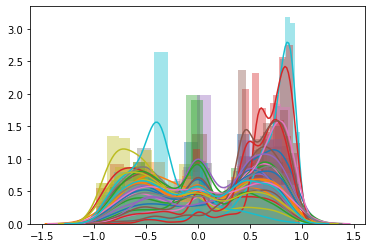

In [106]:
# Get Sentiment analysis distribution for each group
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

SA_pd = pd.DataFrame()
for i in range(0, 30):
    temp = res[res.label == i]
    scores = [analyzer.polarity_scores(row["text"])["compound"] for i, row in temp.iterrows()]
    ax = sns.distplot(scores)
    SA_pd[i] = ax.lines[i].get_ydata()
    

# sort by descending compound score 
SA_pd = SA_pd[topKeywords.Topic.values]

print(SA_pd.shape)
SA_pd.head()

In [107]:
SA_pd.to_csv("SA_scores_20190713.csv", sep=";")

In [8]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, metric="cosine")
np.set_printoptions(suppress=True)

X_tsne = np.asarray(res["text_vec"].values.tolist())
print(X_tsne.shape)
Y=model.fit_transform(X_tsne)
 


(164466, 200)


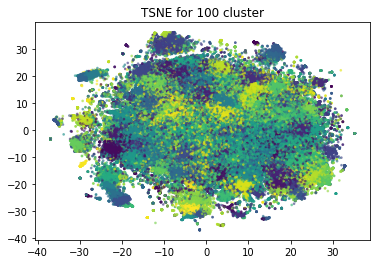

In [13]:
import matplotlib.pyplot as plt
plt.scatter(Y[:, 0], Y[:, 1], c=res["label"], s=3,alpha=.5)

plt.title("TSNE for {} cluster".format(Ncluster))
plt.savefig("TSNE_K_{}".format(Ncluster))
#for j in range(len(sentences)):    
#   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
#   print ("%s %s" % (assigned_clusters[j],  sentences[j]))
  
#plt.show()

In [15]:
print(data.gender.value_counts())

print(data.typeDiabetes.value_counts())

1    65106
0    55311
2    44049
Name: gender, dtype: int64
0    106065
1     45830
2     12571
Name: typeDiabetes, dtype: int64


In [6]:
def get_groupCenter(group, vectorColumn="text_vec"):
    matrix_form = np.asarray(group[vectorColumn].values.tolist())
    groupCenter = np.sum(matrix_form,axis=0) / matrix_form.shape[0]
    
    #group["cos_similarity_to_center"] = group["text_vec"].map(lambda vec: cosinus_similarity(vec, groupCenter))
    #group.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    print(type(groupCenter), groupCenter.shape)
    return(groupCenter)


#res1 = print_closest_tweets_to_groupCenter(res, 10, "text_vec")
dataCenters = data.groupby(by="label", as_index=False) \
              .apply(lambda group: get_groupCenter(group, "text_vec")) \
              .reset_index(drop=True)

print(dataCenters.shape, type(dataCenters))

<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
(30,) <class 'pandas.core.series.Series

In [6]:
from defines import *

PrimaryEmotionTree_allwords = {}
for primaryEmotion in ParrotsEmotionsTree.keys(): 
#    PrimaryEmotionTree_allwords[primaryEmotion] = all_word_forms(get_parrotsEmotions_for_emtion(primaryEmotion))
    PrimaryEmotionTree_allwords[primaryEmotion] =  list(set(get_synonyms(all_word_forms(get_parrotsEmotions_for_emtion(primaryEmotion)),
                                                        Emotions.excludeSynonyms_, Emotions.addWords_)))
    print(primaryEmotion, len(PrimaryEmotionTree_allwords[primaryEmotion]))
print()    
#PrimaryEmotionTree_allwords
# delete all words that were manually deleted in emotions_full_list
for primaryEmotion in PrimaryEmotionTree_allwords.keys():
    for word in PrimaryEmotionTree_allwords[primaryEmotion]:
        if word not in Emotions.emotions_full_list: 
            #print(word)
            PrimaryEmotionTree_allwords[primaryEmotion].remove(word)
    print(primaryEmotion, len(PrimaryEmotionTree_allwords[primaryEmotion]))



love 274
joy 440
surprise 39
anger 432
sadness 465
fear 264

love 198
joy 355
surprise 35
anger 376
sadness 371
fear 206


In [68]:
PrimaryEmotionTree_allwords["surprise"]

['surprised',
 'astonied',
 'stupefy',
 'flummox',
 'mystify',
 'amazement',
 'astounded',
 'stupefying',
 'astonishment',
 'amazing',
 'astound',
 'amaze',
 'surprise',
 'surpriser',
 'perplex',
 'amazed',
 'awful',
 'staggering',
 'bewilder',
 'astonishing',
 'astounding',
 'nonplus',
 'surprisal',
 'beat',
 'stunned',
 'dumbfound',
 'surprising',
 'puzzle',
 'awing',
 'astonished',
 'astonish',
 'baffle',
 'gravel',
 'awesome']

In [1]:
import pandas as pd
data = pd.read_csv("/home/adrian/Downloads/FastText_Kmeans_Topics - SA_scores_20190715.csv", index_col=0)
print(data.columns)
#print(data.head())

Index(['13', '9', '25', '16', '23', '0', '15', '24', '12', '2', '27', '6',
       '14', '20', '10', '26', '4', '11', '21', '8', '29', '17', '1', '5', '7',
       '22', '28', '3', '19', '18'],
      dtype='object')


In [34]:
import numpy as np
interval = np.linspace(-1,1,128)
s = ""
for i, row in data.iterrows():
    
    s += "({}, {}) ".format(round(float(interval[i]), 5), round(float(row["18"].replace(",", ".")), 5))
s

'(-1.0, 0.00065) (-0.98425, 0.00112) (-0.9685, 0.00195) (-0.95276, 0.00336) (-0.93701, 0.00564) (-0.92126, 0.00923) (-0.90551, 0.01469) (-0.88976, 0.02278) (-0.87402, 0.03438) (-0.85827, 0.05055) (-0.84252, 0.07243) (-0.82677, 0.10118) (-0.81102, 0.13787) (-0.79528, 0.18334) (-0.77953, 0.23805) (-0.76378, 0.30196) (-0.74803, 0.37444) (-0.73228, 0.45421) (-0.71654, 0.53936) (-0.70079, 0.62746) (-0.68504, 0.71572) (-0.66929, 0.80118) (-0.65354, 0.88101) (-0.6378, 0.95268) (-0.62205, 1.01422) (-0.6063, 1.06437) (-0.59055, 1.10261) (-0.5748, 1.12921) (-0.55906, 1.1451) (-0.54331, 1.15169) (-0.52756, 1.15068) (-0.51181, 1.14379) (-0.49606, 1.13254) (-0.48031, 1.11806) (-0.46457, 1.10102) (-0.44882, 1.08158) (-0.43307, 1.05951) (-0.41732, 1.03434) (-0.40157, 1.00558) (-0.38583, 0.97286) (-0.37008, 0.93615) (-0.35433, 0.89577) (-0.33858, 0.85245) (-0.32283, 0.80722) (-0.30709, 0.76128) (-0.29134, 0.7159) (-0.27559, 0.67224) (-0.25984, 0.63127) (-0.24409, 0.59374) (-0.22835, 0.56015) (-0.2126,

In [52]:
import numpy as np
interval = np.linspace(0,1,128)
s = ""
for i, row in data.iterrows():
    
    s += "({}, {}) ".format(round(float(interval[i]), 5), round(float(row["18"].replace(",", ".")), 5))
s

'(0.0, 0.00065) (0.00787, 0.00112) (0.01575, 0.00195) (0.02362, 0.00336) (0.0315, 0.00564) (0.03937, 0.00923) (0.04724, 0.01469) (0.05512, 0.02278) (0.06299, 0.03438) (0.07087, 0.05055) (0.07874, 0.07243) (0.08661, 0.10118) (0.09449, 0.13787) (0.10236, 0.18334) (0.11024, 0.23805) (0.11811, 0.30196) (0.12598, 0.37444) (0.13386, 0.45421) (0.14173, 0.53936) (0.14961, 0.62746) (0.15748, 0.71572) (0.16535, 0.80118) (0.17323, 0.88101) (0.1811, 0.95268) (0.18898, 1.01422) (0.19685, 1.06437) (0.20472, 1.10261) (0.2126, 1.12921) (0.22047, 1.1451) (0.22835, 1.15169) (0.23622, 1.15068) (0.24409, 1.14379) (0.25197, 1.13254) (0.25984, 1.11806) (0.26772, 1.10102) (0.27559, 1.08158) (0.28346, 1.05951) (0.29134, 1.03434) (0.29921, 1.00558) (0.30709, 0.97286) (0.31496, 0.93615) (0.32283, 0.89577) (0.33071, 0.85245) (0.33858, 0.80722) (0.34646, 0.76128) (0.35433, 0.7159) (0.3622, 0.67224) (0.37008, 0.63127) (0.37795, 0.59374) (0.38583, 0.56015) (0.3937, 0.53077) (0.40157, 0.50574) (0.40945, 0.48505) (0.

In [13]:
np.linspace(0,1,128)

array([0.        , 0.00787402, 0.01574803, 0.02362205, 0.03149606,
       0.03937008, 0.04724409, 0.05511811, 0.06299213, 0.07086614,
       0.07874016, 0.08661417, 0.09448819, 0.1023622 , 0.11023622,
       0.11811024, 0.12598425, 0.13385827, 0.14173228, 0.1496063 ,
       0.15748031, 0.16535433, 0.17322835, 0.18110236, 0.18897638,
       0.19685039, 0.20472441, 0.21259843, 0.22047244, 0.22834646,
       0.23622047, 0.24409449, 0.2519685 , 0.25984252, 0.26771654,
       0.27559055, 0.28346457, 0.29133858, 0.2992126 , 0.30708661,
       0.31496063, 0.32283465, 0.33070866, 0.33858268, 0.34645669,
       0.35433071, 0.36220472, 0.37007874, 0.37795276, 0.38582677,
       0.39370079, 0.4015748 , 0.40944882, 0.41732283, 0.42519685,
       0.43307087, 0.44094488, 0.4488189 , 0.45669291, 0.46456693,
       0.47244094, 0.48031496, 0.48818898, 0.49606299, 0.50393701,
       0.51181102, 0.51968504, 0.52755906, 0.53543307, 0.54330709,
       0.5511811 , 0.55905512, 0.56692913, 0.57480315, 0.58267

In [55]:
"".join("{"+"{}".format(emot, np.round(occ/sum_occ_primary_emot,2))+"}" for emot, occ in primaryEmotion_str)


NameError: name 'primaryEmotion_str' is not defined

In [56]:
import pandas as pd
data = pd.read_parquet("/home/adrian/PhD/Data/Tweets20190708/matching-tweets_diab_noRT-noBots_personal_noJokes_locationUS_geoCityCodeNotNull_emotions_gender-typeDiab.parquet", columns=["id", "text", "user_name", "gender", "typeDiabetes", "geo_adm1_code", "geo_name", "user_location", "place_full_name"])
data.columns

Index(['id', 'text', 'user_name', 'gender', 'typeDiabetes', 'geo_adm1_code',
       'geo_name', 'user_location', 'place_full_name'],
      dtype='object')

In [61]:
data.gender.value_counts().map(lambda v: str(v)+" "+str(round(v/data.shape[0], 2)))

1    20228 0.44
0    14485 0.31
2    11694 0.25
Name: gender, dtype: object

In [62]:
data.typeDiabetes.value_counts().map(lambda v: str(v)+" "+str(round(v/data.shape[0], 2)))

0    21747 0.47
1    20285 0.44
2     4375 0.09
Name: typeDiabetes, dtype: object